In [1]:
#All the following script and comments have been made in accordance to Merged heart data##

#Importing packages # Make sure that you activate correct environment 
import pandas as pd
import scanpy as sc
import numpy as np
import os
from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.sparse import csr_matrix, issparse

#Setting up to avoid kernel crashes
os.environ['PYDEVD_DISABLE_FILE_VALIDATION'] = '1'


sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor="white")

#writing output file
results_file = "./outputs/trail/clean_data_scanpy.h5ad"

/Users/srivalli/conda/envs/scanpy/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


scanpy==1.9.8 anndata==0.10.5.post1 umap==0.5.5 numpy==1.26.4 scipy==1.12.0 pandas==2.2.1 scikit-learn==1.4.1.post1 statsmodels==0.14.1 igraph==0.10.8 louvain==0.8.1 pynndescent==0.5.11


In [2]:
#Reading the h5ad file
clean_data = sc.read_h5ad("/Users/srivalli/Desktop/SCA-Uni/Single-cell-data-analysis/Cardiac_cell_analysis/outputs/merged_heart.h5ad")
clean_data

AnnData object with n_obs × n_vars = 1190430 × 66270
    obs: 'NRP', 'age_group', 'cell_source', 'cell_type', 'donor', 'sex', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'sample', 'scrublet_score', 'source', 'type', 'version', 'cell_states', 'Used', 'sangerID', 'combinedID', 'donor_type', 'region_finest', 'age', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'scrublet_leiden', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'batch_key', 'leiden_scVI', 'cell_state_HCAv1', 'cell_state_scNym', 'cell_state_scNym_confidence', 'cell_state', 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', '_scvi_batch', '_scvi_labels', 'clus20', 'doublet_cls', 'original_or_new', 'batch', 'scANVI_predictions', 'leiden_scArches'
    obsm: 'X_pca', 'X_scArches', 'X_umap'

In [3]:
# Identify duplicated cells based on their annotation information
duplicated_cell_names = clean_data.obs.index[clean_data.obs.duplicated()]

# Print the names of duplicated cells
print("Duplicated cell names:")
print(duplicated_cell_names)

# Identify duplicated cells based on their annotation information
duplicated_cells = clean_data.obs.duplicated()

# Filter out duplicated cells
clean_data = clean_data[~duplicated_cells, :]

# Check the size of the dataset before and after deduplication
print("Size before deduplication:", clean_data.shape)

# Remove any cells with zero genes after deduplication (optional)
clean_data = clean_data[clean_data.obs.n_genes_by_counts > 0, :]

# Check the size of the dataset after removing cells with zero genes
print("Size after deduplication:", clean_data.shape)

Duplicated cell names:
Index([], dtype='object')
Size before deduplication: (1190430, 66270)
Size after deduplication: (704296, 66270)


normalizing counts per cell
    finished (0:00:45)


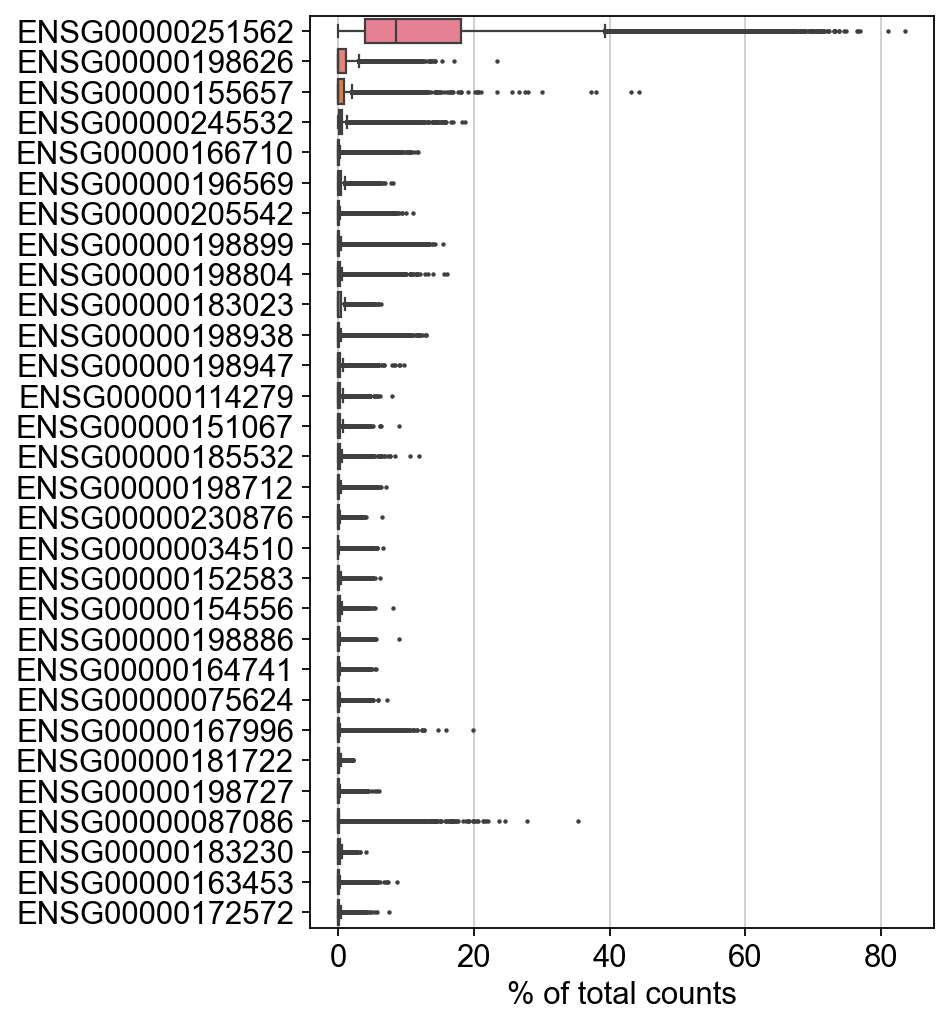

In [4]:
#PREPROCESSING#

#Making var names unique
clean_data.var_names_make_unique()

#Viewing genes that contributes the largest portion in a cell
highest_expr_genes = sc.pl.highest_expr_genes(clean_data)

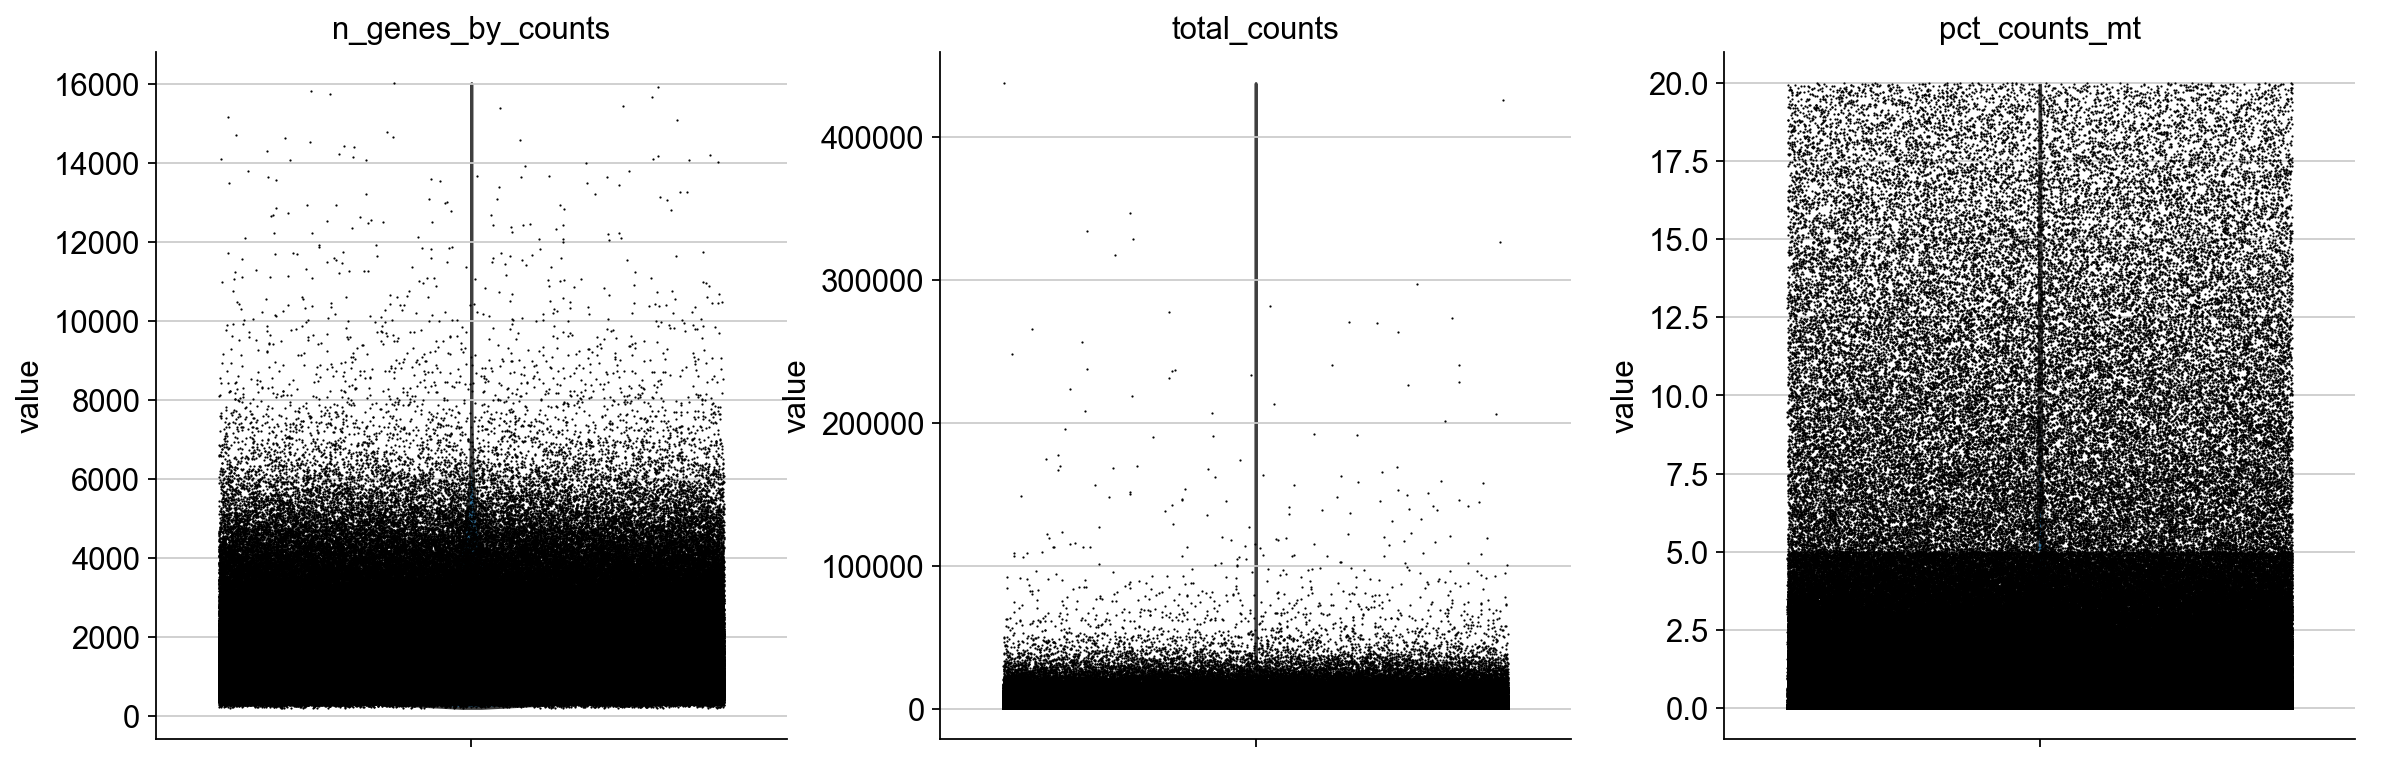

In [5]:
sc.pl.violin(clean_data,["n_genes_by_counts", "total_counts", "pct_counts_mt"],jitter=0.4,multi_panel=True)

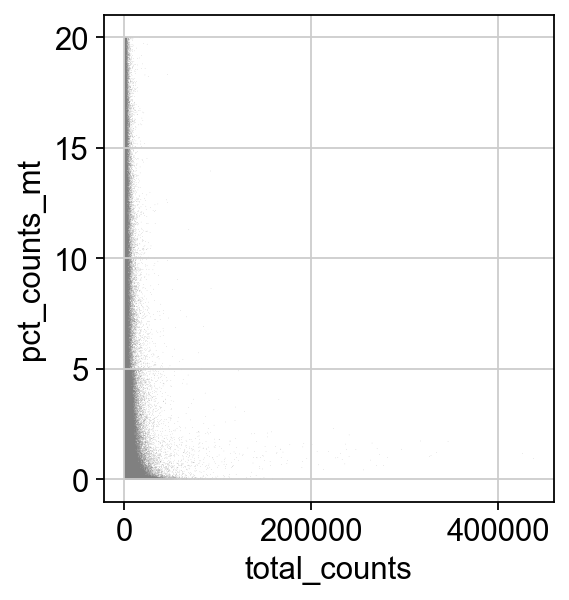

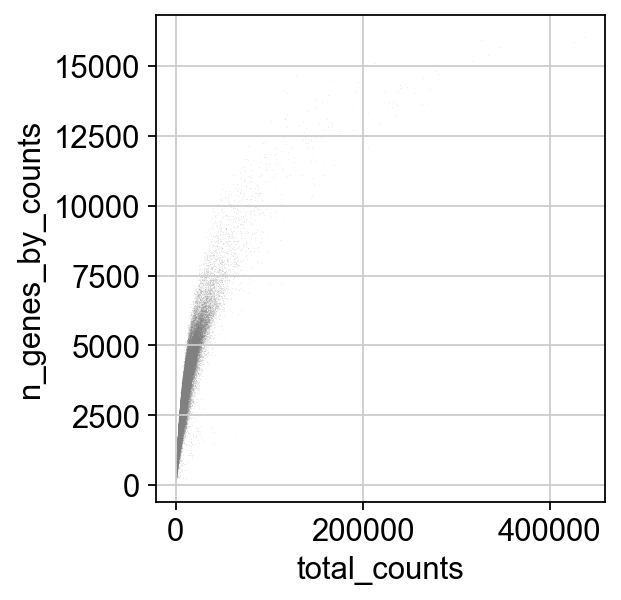

In [6]:
#Scatter plots
sc.pl.scatter(clean_data, x="total_counts", y="pct_counts_mt")
sc.pl.scatter(clean_data, x="total_counts", y="n_genes_by_counts")

In [7]:
#Filtering genes and cells 
sc.pp.filter_cells(clean_data, min_genes=200)
sc.pp.filter_genes(clean_data, min_cells=20)

#Above filtering considers only cells having min 200 genes as a primary criteria and filters the genes which are found in minimum of 20 cells
#CAN BE MODIFIED

filtered out 1 cells that have less than 200 genes expressed
filtered out 36566 genes that are detected in less than 20 cells


In [8]:
#Normalization using Pearson
#analytic_pearson = sc.experimental.pp.normalize_pearson_residuals(clean_data)

#Normalizing data matrix using CPM
#sc.pp.normalize_total(clean_data,target_sum=1e6)

#Logarithmization of data
#sc.pp.log1p(clean_data,base=2)

#Adding to layers
#clean_data.layers['normalized_log1p'] = clean_data.X.copy()
#clean_data.layers["analytic_pearson_residuals"] = csr_matrix(analytic_pearson["X"])

#Plotting
#fig, axes = plt.subplots(1, 2, figsize=(10, 5))
#p1 = sns.histplot(clean_data.obs["total_counts"], bins=100, kde=False, ax=axes[0])
#axes[0].set_title("Total counts")
#p2 = sns.histplot(
   # clean_data.layers["analytic_pearson_residuals"].sum(1), bins=100, kde=False, ax=axes[1]
#)
#axes[1].set_title("Analytic Pearson residuals")
#plt.show()

In [14]:
np.isinf(clean_data)

In [ ]:
np.nan_to_num(clean_data)

In [13]:
#Calculating dispersion of highly variable genes
sc.pp.highly_variable_genes(clean_data,flavor= 'seurat',n_bins= 30)

#Identifying high variable genes satisfying conditions
sc.pp.highly_variable_genes(clean_data, min_mean=0.0125, max_mean=3, min_disp=0.5)
clean_data = sc.pl.highly_variable_genes(clean_data)

extracting highly variable genes


/Users/srivalli/conda/envs/scanpy/lib/python3.12/site-packages/scipy/sparse/_data.py:149: RuntimeWarning: overflow encountered in expm1
  result = op(self._deduped_data())


ValueError: cannot specify integer `bins` when input data contains infinity

In [ ]:
#Writing file
clean_data.write("heart_normalized.h5ad")

In [ ]:
##PRINCIPAL COMPONENT ANALYSIS##

#Reducing dimensions
sc.tl.pca(clean_data, svd_solver="arpack",use_highly_variable=True)

#To view the principal components
clean_data.obsm['X_pca']

#Scatter plot for PCA components for visualization 
sc.pl.pca(clean_data)

In [ ]:
#Scatter plot for PCA components for visualization based on coloring of genes
#sc.pl.pca(clean_data,color= "NKG7")

#FIND A GENE

In [ ]:
#Number of PCs to be considered for the data
sc.tl.tsne(clean_data)

#To know the values and count of Principal components
clean_data.obsm['X_pca']

In [ ]:
#Estimates of Principal components contribution to the total variance of the data
sc.pl.pca_variance_ratio(clean_data, log=True)

#Saving results
clean_data.write(results_file)
clean_data

In [ ]:
#Writing all ensg ids into file for conversion

ensg = clean_data.var_names

# Combine the current working directory with the file name
file_name = "ensembl_gene_ids.txt"
file_path = os.path.join("./outputs/trail/", file_name)


with open(file_path, 'w') as file:
    for ensgid in ensg:
        file.write(ensgid + '\n')

In [ ]:
#COMPUTING NEIGHBOUIRHOOD GRAPH#

#General method
#sc.pp.neighbors(clean_data)
#clean_data
#Can add n_neighbors and n_pca parameters if we would like to consider making clusters based on given params#

#NOT USING THIS

In [ ]:
#Computing neighbors by bbknn - Batch balanced KNN

clean_data = sc.external.pp.bbknn(clean_data)


In [ ]:
#EMBEDDING THE NEIGHBOURHOOD GRAPH

#Assinging cells to clusters
sc.tl.leiden(clean_data)

#Partioning data and identifying relationships between clusters
sc.tl.paga(clean_data)
sc.pl.paga(clean_data)

#Data visualization
sc.tl.umap(clean_data)

#Giving colour codes for better visulauization based on genes
sc.pl.umap(clean_data, color=["leiden"])

In [ ]:
#Ranking genes using wilcoxon method
sc.tl.rank_genes_groups(clean_data, "leiden", method="wilcoxon")

#Plotting 
sc.pl.rank_genes_groups(clean_data, n_genes=25, sharey=False)

#Saving data
clean_data.write(results_file)

In [ ]:
#Using logistic regression
sc.tl.rank_genes_groups(clean_data, "leiden", method="logreg", max_iter=100)
sc.pl.rank_genes_groups(clean_data, n_genes=25, sharey=False)

In [ ]:
#To get list of gene names across clusters
gene_clusters = pd.DataFrame(clean_data.uns["rank_genes_groups"]["names"])

gene_clusters.to_csv("./outputs/trail/gene_clusters.csv")
#Can add .head(10) at the end to give output of only 10 hits

In [ ]:
#Getting table with scores and group
clean_data = sc.read(results_file)
result = clean_data.uns["rank_genes_groups"]
groups = result["names"].dtype.names
scores = pd.DataFrame(
    {
        group + "_" + key[:1]: result[key][group]
        for group in groups
        for key in ["names", "pvals"]
    }
)

scores.to_csv("./outputs/trail/scores.csv")
#low p-value indicates that the gene is likely differentially expressed in that cluster compared to others

In [ ]:
#Saving file
clean_data.write(results_file)